In [59]:
# roc curve and auc
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, plot_roc_curve, precision_score, roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt

## For a specific fold

In [66]:
root = "/media/visiopharm5/WDGold/deeplearning/MIL/CLAM/results/training_custom/shufflenet"
target = "tcga_hcc-hard_tumor-masked_349_6G_Interferon_Gamma_cv_highvsrest_622_shufflenet_frz3_imagenet_s1"
fold = 0
path = os.path.join(root, target)
file = os.path.join(path, "split_{}_results.pkl".format(str(fold)))
print(file)

/media/visiopharm5/WDGold/deeplearning/MIL/CLAM/results/training_custom/shufflenet/tcga_hcc-hard_tumor-masked_349_6G_Interferon_Gamma_cv_highvsrest_622_shufflenet_frz3_imagenet_s1/split_0_results.pkl


In [67]:
unpickled_dict = pd.read_pickle(file)
print('Batch number: {}'.format(len(unpickled_dict.keys())))
print(unpickled_dict.keys())

Batch number: 262
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2

### unpickled_dict structure:
1. unpickled_dict.keys(): batch level
2. unpickled_dict[batch_ind]: batch size, tile_ids (of this batch), probs (of total patches), labels (of previous batches and this one)

In [68]:
tile_ids = []

for i in range(len(unpickled_dict.keys())):
    tile_ids.extend(unpickled_dict[i]['tile_ids'])
#     print('tile_id number of batch {}: {}'.format(i, len(unpickled_dict[i]['tile_ids'])))
#     print('probs number of batch {}: {}'.format(i, len(unpickled_dict[i]['probs'])))
#     print('labels number of batch {}: {}'.format(i, len(unpickled_dict[i]['labels'])))
#     print()
    
print('Batch size: {}'.format(len(unpickled_dict[i-1]['tile_ids'])))
print('Total patches: {}'.format(len(tile_ids)))

Batch size: 128
Total patches: 33500


In [69]:
print(tile_ids[0])
print(tile_ids[1])

TCGA-DD-AACB-01Z-00-DX1.D4A7846E-8B38-4FBA-BAB3-BDAF2EC84E9E:702
TCGA-DD-AACB-01Z-00-DX1.D4A7846E-8B38-4FBA-BAB3-BDAF2EC84E9E:2539


In [70]:
probs = []
labels = unpickled_dict[len(unpickled_dict.keys())-1]['labels'] # directly take the last batch

for j in range(len(unpickled_dict[len(unpickled_dict.keys())-1]['probs'])): # directly last batch
    probs.append(unpickled_dict[len(unpickled_dict.keys())-1]['probs'][j][1]) # (prob_class0, prob_class1)
    
print(len(probs))
print(len(labels))

33500
33500


(0, 1)

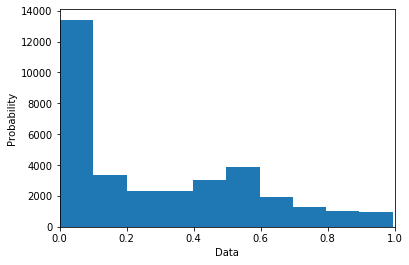

In [71]:
plt.hist(np.array(probs), density=False, bins=10)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.xlim((0, 1))

ROC AUC=0.438


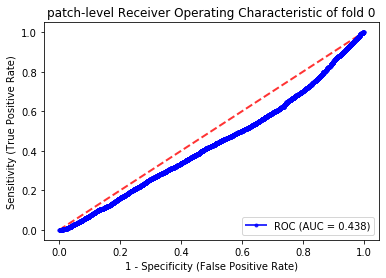

In [72]:
draw_roc(labels, probs, "patch")
threshold = Find_Optimal_Cutoff(labels, probs, "patch")[0]

TCGA-DD-AACB-01Z-00-DX1.D4A7846E-8B38-4FBA-BAB3-BDAF2EC84E9E
ROC AUC=0.400


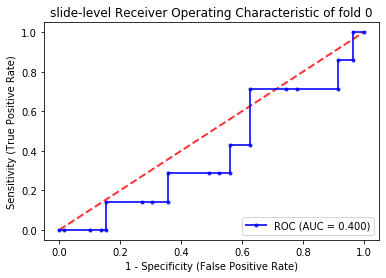

[0.494]

In [73]:
slide_id = tile_ids[0].split(":")[0] # first slide name
print(slide_id)

n_patches = 0
n_positives = 0
slide_probs = {}
slide_labels = {}

for i in range(len(tile_ids)):
    if slide_id != tile_ids[i].split(":")[0]: # next slide
        # process last slide
        slide_probs[slide_id] = n_positives / n_patches
        slide_labels[slide_id] = labels[i]
        # current slide
        slide_id = tile_ids[i].split(":")[0]
        n_patches = 0
        n_positives = 0
    if probs[i] >= threshold: # positive with patch-level threshold
        n_positives = n_positives + 1
    n_patches = n_patches + 1
  
# print(slide_probs)
# print(slide_labels)

draw_roc(list(slide_labels.values()), list(slide_probs.values()), "slide")
Find_Optimal_Cutoff(list(slide_labels.values()), list(slide_probs.values()), "slide")

TCGA-DD-AAEH-01Z-00-DX
ROC AUC=0.594


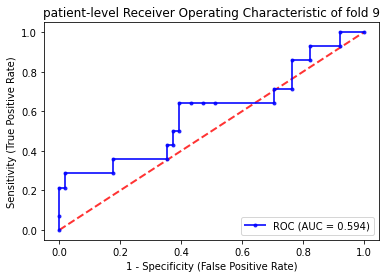

[0.512]

In [145]:
# patient_id = tile_ids[0].split(".")[0][:-1]
# print(patient_id)

# n_patches = 0
# n_positives = 0
# patient_probs = {}
# patient_labels = {}

# for i in range(len(tile_ids)):
#     if patient_id != tile_ids[i].split(".")[0][:-1]:
#         patient_probs[patient_id] = n_positives / n_patches
#         patient_labels[patient_id] = labels[i]
#         patient_id = tile_ids[i].split(".")[0][:-1]
#         n_patches = 0
#         n_positives = 0
#     if probs[i] >= threshold:
#         n_positives = n_positives + 1
#     n_patches = n_patches + 1
  
# # print(patient_probs)
# # print(patient_labels)

# draw_roc(list(patient_labels.values()), list(patient_probs.values()), "patient")
# Find_Optimal_Cutoff(list(patient_labels.values()), list(patient_probs.values()), "patient")

## For all the fold

In [84]:
root = "/media/visiopharm5/WDGold/deeplearning/MIL/CLAM/results/training_custom/shufflenet"
target = "tcga_hcc-hard_tumor-masked_349_6G_Interferon_Gamma_cv_highvsrest_622_shufflenet_frz3_imagenet_s1"
path = os.path.join(root, target)
folds = 2
        
labels_for_roc = []
probs_for_roc = []

In [85]:
# depends on function roc_curve()
def Find_Optimal_Cutoff(target, probs, level):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    probs: Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, probs)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# # Add prediction probability to dataframe
# # data['pred_proba'] = result.predict(data[train_cols])

# # Find optimal probability threshold
# threshold = Find_Optimal_Cutoff(target, probs)
# print(threshold)
# # [0.31762762459360921]

# # Find prediction to the dataframe applying threshold
# preds = [1 if prob > threshold else 0 for prob in probs]

# # Print confusion Matrix
# from sklearn.metrics import confusion_matrix
# consm = confusion_matrix(target, preds)
# # array([[175,  98],
# #        [ 46,  81]])

# with open(os.path.join(path, "roc_split_{}_results_{}.txt".format(str(fold), level)),"w+") as file:
#     file.write("Fold " + str(fold) + "!")
#     file.write("\n\nOptimal threshold:\n")
#     file.write(str(threshold[0]))
#     file.write("\n\nConfusion matrix:\n")
#     file.write(str(consm))

In [86]:
# draw ROC for a single split
def draw_roc(labels, probs, level):
    auc = roc_auc_score(labels, probs)
    # summarize scores
    print('ROC AUC=%.3f' % (auc))
    # calculate roc curves
    fpr, tpr, _ = roc_curve(labels, probs)
    # plot the roc curve for the model
    pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',alpha=.8)
    # set marker to check the prob distribution
    pyplot.plot(fpr, tpr, marker='.', color='b',label=r'ROC (AUC = %0.3f)' % (auc),lw=2, alpha=.8) 
    # axis labels
    pyplot.title("{}-level Receiver Operating Characteristic of fold {}".format(level, str(fold)))
    pyplot.xlabel('1 - Specificity (False Positive Rate)')
    pyplot.ylabel('Sensitivity (True Positive Rate)')
    # show the legend
    pyplot.legend(loc="lower right")
    # save figure
#     pyplot.savefig(os.path.join(path, "roc_split_{}_{}.png".format(str(fold), level)))
    # show the plot
    pyplot.show()

In [87]:
# #############################################################################
# ROC analysis
def draw_mean_roc(k = 10, labels_for_roc = labels_for_roc, probs_for_roc = probs_for_roc):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # print(X[test].shape, y[test].shape)

    fig, ax = plt.subplots()
#     counter = 0
    for i in range(k):
        
        fpr, tpr, thresholds = roc_curve(labels_for_roc[i], probs_for_roc[i])
#         print(counter,counter+nslides[i])
        ax.plot(fpr, tpr, alpha=0.3, lw=1)
    #     ax.plot(viz.fpr, viz.tpr, label='ROC fold {}'.format(i), alpha=0.3, lw=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        counter_auc = auc(fpr, tpr)
        aucs.append(counter_auc) # not real auc (plot), but the interpolated auc for mean calculation

#         counter = counter + nslides[i]

    print('\nAUCs: {}'.format(aucs))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            alpha=.8)
    #         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) #####
    std_auc = np.std(aucs) #####
    # can set marker to check the prob distribution, here just disable for simple mean curves
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=str(k) + "-fold Receiver Operating Characteristic")
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1 - Specificity (False Positive Rate)')
    ax.legend(loc="lower right")
    # ax.legend(loc="best")

Patch-level threshold of fold 0: 0.16164113581180573
Patch-level threshold of fold 1: 0.24090427160263062

AUCs: [0.39951573849878935, 0.6428571428571428]


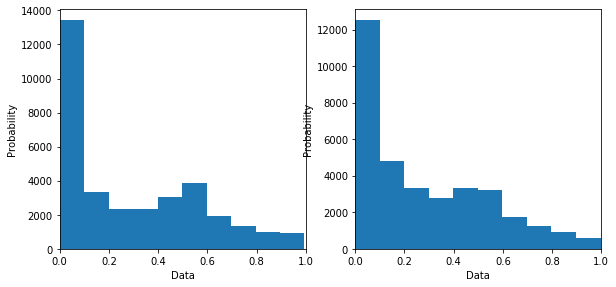

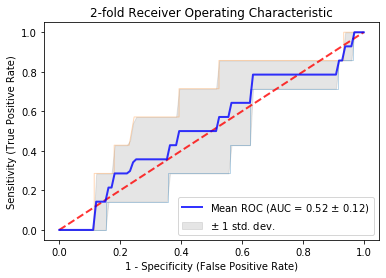

In [88]:
fig = plt.figure(figsize=(15,15))

for fold in range(folds):
    file = os.path.join(path, "split_{}_results.pkl".format(str(fold)))
    unpickled_dict = pd.read_pickle(file)

    tile_ids = []
    for i in range(len(unpickled_dict.keys())):
        tile_ids.extend(unpickled_dict[i]['tile_ids'])
        
    probs = []
    labels = unpickled_dict[len(unpickled_dict.keys())-1]['labels']
    for j in range(len(unpickled_dict[len(unpickled_dict.keys())-1]['probs'])):
        probs.append(unpickled_dict[len(unpickled_dict.keys())-1]['probs'][j][1])
        
    # plot histogram for patch-level probabilities 
    fig.add_subplot(3, 3, fold+1)
    plt.hist(np.array(probs), density=False, bins=10)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.xlim((0, 1))
        
    threshold = Find_Optimal_Cutoff(labels, probs, "patch")[0]
    print('Patch-level threshold of fold {}: {}'.format(fold, threshold))
    
    
    slide_id = tile_ids[0].split(":")[0]

    n_patches = 0
    n_positives = 0
    slide_probs = {}
    slide_labels = {}

    for i in range(len(tile_ids)):
        if slide_id != tile_ids[i].split(":")[0]:
            slide_probs[slide_id] = n_positives / n_patches
            slide_labels[slide_id] = labels[i]
            slide_id = tile_ids[i].split(":")[0]
            n_patches = 0
            n_positives = 0
        if probs[i] >= threshold:
            n_positives = n_positives + 1
        n_patches = n_patches + 1

    labels_for_roc.append(list(slide_labels.values()))
    probs_for_roc.append(list(slide_probs.values()))

draw_mean_roc(k = folds, labels_for_roc = labels_for_roc, probs_for_roc = probs_for_roc)
# plt.savefig(os.path.join(path, "roc.png"))
plt.show()